# Copyright Netherlands eScience Center <br>
** Function     : Paper Figure - AMET & OMET mean and time series ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.03.08 ** <br>
** Last Update  : 2019.03.25 ** <br>
Description  : This script serves to prepare figures for the paper about the Bjerknes compensation. It calculates the meridional energy transport in the atmosphere as the residual of net radiation flux at top of the atmosphere and the net surface flux at the sea surface. OMET and OMET anomalies are included here as well.<br>
Return Values : jpeg <br>
Caveat!         : The AMET is computed as the residual of net flux at TOA and surface. <br>
For all the flux generated by ECMWF model, **downward is positive** (regardless of the standard name). So it is with **ERA-Interim** <br>
While for the flux in **MERRA2**, the **positive sign** for each variable varies:<br>
* Net shortwave radiation at surface - downward <br>
* Net shortwave radiation at TOA - downward <br>
* Net longwave radiation at surface - downward <br>
* Upwelling longwave radiation at TOA - upward <br>
* Total latent energy flux - upward <br>
* Sensible heat flux - upward <br>

While for the flux in **JRA55**, the **positive sign** for each variable varies:<br>
* Latent heat flux - upward <br>
* Sensible heat flux - upward <br>
* Downward solar radiation flux at TOA - downward <br>
* Downward solar radiation flux at surface - downward <br>
* Downward longwave radiation flux at surface - downward <br>
* Upward solar radiation flux at TOA - upward <br>
* Upward solar radiation flux at surface - upward <br>
* Upward longwave radiation flux at TOA - upward <br>
* Upward longwave radiation flux at surface - upward <br>

Here we use the net radiation flux of JRA55 after post-processing, as follows: <br>
* Net radiation at TOA - downward <br>
* Net radiation at surface - downward <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer
from scipy import stats

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
print ('****************************************************************************')
print ('********************    latitude index of insteret     *********************')
print ('****************************************************************************')
# 60N
lat_ERAI_60 = 40
lat_MERRA2_60 = 80
lat_JRA55_60 = 53

lat_ORAS4_60 = 233
lat_GLORYS2V3_60 = 788
lat_SODA3_60 = 789
# after a cut to 20-90 N
lat_ORAS4_60_cut = 53
lat_GLORYS2V3_60_cut = 209
lat_SODA3_60_cut = 220

****************************************************************************
********************    latitude index of insteret     *********************
****************************************************************************


In [4]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
    datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
    datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/MET_Feedback/figures'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    dataset_MERRA2_fields_flux = Dataset(os.path.join(datapath_MERRA2_fields,
                                                      'surface_merra_monthly_regress_1980_2017_SFlux_Rad.nc'))
    dataset_JRA55_fields_flux = Dataset(os.path.join(datapath_JRA55_fields,
                                                     'surface_JRA55_monthly_model_regress_SFlux_Rad_1979_2013.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath_ORAS4,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_GLORYS2V3_OMET = Dataset(os.path.join(datapath_GLORYS2V3,
                                                  'GLORYS2V3_model_monthly_orca025_E_zonal_int.nc'))
    dataset_SODA3_OMET = Dataset(os.path.join(datapath_SODA3,
                                              'OMET_SODA3_model_5daily_1980_2015_E_zonal_int.nc'))
    # extract time series
    # from 20N - 90N
    OMET_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_GLORYS2V3 = dataset_GLORYS2V3_OMET.variables['E'][:,:,579:]/1000 # from Tera Watt to Peta Watt # start from 1993
    OMET_SODA3 = dataset_SODA3_OMET.variables['E'][:,:,569:]/1000
    # dimensions info
    # time
    year_ERAI = dataset_ERAI_fields_flux.variables['year'][:-1]
    year_MERRA2 = dataset_MERRA2_fields_flux.variables['year'][:-1]
    year_JRA55 = dataset_JRA55_fields_flux.variables['year']
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]
    year_GLORYS2V3 = dataset_GLORYS2V3_OMET.variables['year'][:]
    year_SODA3 = dataset_SODA3_OMET.variables['year'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
    # reverse the latitude of MERRA2 fields
    latitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['latitude'][::-1]
    longitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['longitude'][:]
    latitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['latitude'][:]
    longitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['longitude'][:]
    # ocean grid
    latitude_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_GLORYS2V3 = dataset_GLORYS2V3_OMET.variables['latitude_aux'][579:]
    latitude_SODA3 = dataset_SODA3_OMET.variables['latitude_aux'][569:]

*********************** extract variables *************************


In [5]:
    #####################################################################################
    print ('*********************** post-process 4D fields *************************')    
    # 4D fields [year, month, level, lat]
    # downward is positive for all the fluxes
    print ('*********************** post-process era fields *************************')
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI[:] + rad_long_surf_ERAI[:] +\
                         SFlux_sensible_ERAI[:] + SFlux_latent_ERAI[:]
    net_flux_toa_ERAI = rad_short_toa_ERAI[:] + rad_long_toa_ERAI[:]    
    # save memory
    del rad_short_toa_ERAI, rad_long_toa_ERAI, rad_short_surf_ERAI, rad_long_surf_ERAI
    del SFlux_sensible_ERAI, SFlux_latent_ERAI    
    print ('*********************** post-process merra fields *************************')
    rad_short_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['SWTNT'][:-1,:,:,:]
    rad_long_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['LWTUP'][:-1,:,:,:]
    rad_short_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['SWGNT'][:-1,:,:,:]
    rad_long_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['LWGNT'][:-1,:,:,:]
    SFlux_sensible_MERRA2 = dataset_MERRA2_fields_flux.variables['HFLUX'][:-1,:,:,:]
    SFlux_latent_MERRA2 = dataset_MERRA2_fields_flux.variables['EFLUX'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    # merra - watch out! the sign
    # reverse the meridional coordinate of MERRA2 for the sake of the calc. of residual
    net_flux_surf_MERRA2 = rad_short_surf_MERRA2[:,:,::-1,:] + rad_long_surf_MERRA2[:,:,::-1,:] -\
                           SFlux_sensible_MERRA2[:,:,::-1,:] - SFlux_latent_MERRA2[:,:,::-1,:]
    net_flux_toa_MERRA2 = rad_short_toa_MERRA2[:,:,::-1,:] - rad_long_toa_MERRA2[:,:,::-1,:]
    del rad_short_toa_MERRA2, rad_long_toa_MERRA2, rad_short_surf_MERRA2, rad_long_surf_MERRA2
    del SFlux_sensible_MERRA2, SFlux_latent_MERRA2
    print ('*********************** post-process jra fields *************************')
    rad_net_toa_JRA55 = dataset_JRA55_fields_flux.variables['nRadT'][:]
    rad_net_surf_JRA55 = dataset_JRA55_fields_flux.variables['nRadS'][:]
    SFlux_sensible_JRA55 = dataset_JRA55_fields_flux.variables['SFlux'][:]
    SFlux_latent_JRA55 = dataset_JRA55_fields_flux.variables['LFlux'][:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_JRA55 = rad_net_surf_JRA55[:] + SFlux_sensible_JRA55[:] +\
                          SFlux_latent_JRA55[:]
    net_flux_toa_JRA55 = rad_net_toa_JRA55[:]
    del rad_net_surf_JRA55, SFlux_sensible_JRA55, SFlux_latent_JRA55
    print ('*********************** convert W/m2 to  *************************')
    # area weighted surface flux
    # era
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float)
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    # merra
    net_flux_surf_MERRA2_area = np.zeros(net_flux_surf_MERRA2.shape, dtype=float)
    net_flux_toa_MERRA2_area = np.zeros(net_flux_toa_MERRA2.shape, dtype=float)
    # jra
    net_flux_surf_JRA55_area = np.zeros(net_flux_surf_JRA55.shape, dtype=float)
    net_flux_toa_JRA55_area = np.zeros(net_flux_toa_JRA55.shape, dtype=float) 
    #size of the grid box
    # era
    dx_ERAI = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy_ERAI = np.pi * constant['R'] / len(latitude_fields_ERAI)
    # merra
    dx_MERRA2 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_MERRA2 /
                                            360) / len(longitude_fields_MERRA2) 
    dy_MERRA2 = np.pi * constant['R'] / len(latitude_fields_MERRA2)
    # jra
    dx_JRA55 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_JRA55 /
                                            360) / len(longitude_fields_JRA55) 
    dy_JRA55 = np.pi * constant['R'] / len(latitude_fields_JRA55)   
    # era
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                           dy_ERAI / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                          dy_ERAI / 1E+12
    # merra
    for i in np.arange(len(latitude_fields_MERRA2)):
        # change the unit to terawatt
        net_flux_surf_MERRA2_area[:,:,i,:] = net_flux_surf_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                           dy_MERRA2 / 1E+12
        net_flux_toa_MERRA2_area[:,:,i,:] = net_flux_toa_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                          dy_MERRA2 / 1E+12
    # jra
    for i in np.arange(len(latitude_fields_JRA55)):
        # change the unit to terawatt
        net_flux_surf_JRA55_area[:,:,i,:] = net_flux_surf_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                           dy_JRA55 / 1E+12
        net_flux_toa_JRA55_area[:,:,i,:] = net_flux_toa_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                          dy_JRA55 / 1E+12

*********************** post-process 4D fields *************************
*********************** post-process era fields *************************
*********************** post-process merra fields *************************
*********************** post-process jra fields *************************
*********************** convert W/m2 to  *************************


In [6]:
    print ('Compute AMET as the residuals of net flux at TOA & surface.')
    print ('*********************** AMET - era fields *************************')
    # take the zonal integral of flux
    net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
    net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
    for i in np.arange(len(latitude_fields_ERAI)-1):
        AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
    print (AMET_res_ERAI.shape)
    print ('*********************** AMET - merra fields *************************')
    # take the zonal integral of flux
    net_flux_surf_MERRA2_int = np.sum(net_flux_surf_MERRA2_area,3) / 1000 # PW
    net_flux_toa_MERRA2_int = np.sum(net_flux_toa_MERRA2_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_MERRA2 = np.zeros(net_flux_surf_MERRA2_int.shape)
    for i in np.arange(len(latitude_fields_MERRA2)-1):
        AMET_res_MERRA2[:,:,i] = -(np.sum(net_flux_toa_MERRA2_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_MERRA2_int[:,:,0:i+1],2))
    print (AMET_res_MERRA2.shape)    
    print ('*********************** AMET - jra fields *************************')
    # take the zonal integral of flux
    net_flux_surf_JRA55_int = np.sum(net_flux_surf_JRA55_area,3) / 1000 # PW
    net_flux_toa_JRA55_int = np.sum(net_flux_toa_JRA55_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_JRA55 = np.zeros(net_flux_surf_JRA55_int.shape)
    for i in np.arange(len(latitude_fields_JRA55)-1):
        AMET_res_JRA55[:,:,i] = -(np.sum(net_flux_toa_JRA55_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_JRA55_int[:,:,0:i+1],2))
    print (AMET_res_JRA55.shape)

Compute AMET as the residuals of net flux at TOA & surface.
*********************** AMET - era fields *************************
(38, 12, 241)
*********************** AMET - merra fields *************************
(37, 12, 361)
*********************** AMET - jra fields *************************
(35, 12, 320)


In [25]:
    # 60N
    print(latitude_fields_MERRA2[60])
    print(latitude_fields_ERAI[40])
    print(latitude_fields_JRA55[53])
    # 20N
    print(latitude_fields_ERAI[94])
    print(latitude_fields_MERRA2[140])
    print(latitude_fields_JRA55[124])
    #print(latitude_ORAS4[53])

60.0
60.0
59.81267
19.5
20.0
19.937572


In [7]:
    print ('*******************************************************************')
    print ('***************   span of annual mean at each lat   ***************')
    print ('*******************************************************************')
    # calculate annual mean
    AMET_ERAI_full_annual_mean = np.mean(AMET_res_ERAI[:,:,:95],1)
    AMET_MERRA2_full_annual_mean = np.mean(AMET_res_MERRA2[:,:,:141],1)
    AMET_JRA55_full_annual_mean = np.mean(AMET_res_JRA55[:,:,:125],1)
    OMET_ORAS4_full_annual_mean = np.mean(OMET_ORAS4,1)
    OMET_GLORYS2V3_full_annual_mean = np.mean(OMET_GLORYS2V3,1)
    OMET_SODA3_full_annual_mean = np.mean(OMET_SODA3,1)
    # calculate the difference between annual mean and mean of entire time series
    AMET_ERAI_full_annual_mean_max = np.amax(AMET_ERAI_full_annual_mean,0)
    AMET_MERRA2_full_annual_mean_max = np.amax(AMET_MERRA2_full_annual_mean,0)
    AMET_JRA55_full_annual_mean_max = np.amax(AMET_JRA55_full_annual_mean,0)
    OMET_ORAS4_full_annual_mean_max = np.amax(OMET_ORAS4_full_annual_mean,0)
    OMET_GLORYS2V3_full_annual_mean_max = np.amax(OMET_GLORYS2V3_full_annual_mean,0)
    OMET_SODA3_full_annual_mean_max = np.amax(OMET_SODA3_full_annual_mean,0)

    AMET_ERAI_full_annual_mean_min = np.amin(AMET_ERAI_full_annual_mean,0)
    AMET_MERRA2_full_annual_mean_min = np.amin(AMET_MERRA2_full_annual_mean,0)
    AMET_JRA55_full_annual_mean_min = np.amin(AMET_JRA55_full_annual_mean,0)
    OMET_ORAS4_full_annual_mean_min = np.amin(OMET_ORAS4_full_annual_mean,0)
    OMET_GLORYS2V3_full_annual_mean_min = np.amin(OMET_GLORYS2V3_full_annual_mean,0)
    OMET_SODA3_full_annual_mean_min = np.amin(OMET_SODA3_full_annual_mean,0)

*******************************************************************
***************   span of annual mean at each lat   ***************
*******************************************************************


In [8]:
    print ('*******************************************************************')
    print ('****************** prepare variables for plot *********************')
    print ('*******************************************************************')
    # annual mean of AMET and OMET at different latitudes
    AMET_ERAI_mean = np.mean(np.mean(AMET_res_ERAI[:,:,:95],0),0)
    AMET_MERRA2_mean = np.mean(np.mean(AMET_res_MERRA2[:,:,:141],0),0)
    AMET_JRA55_mean = np.mean(np.mean(AMET_res_JRA55[:,:,:125],0),0)

    OMET_ORAS4_mean = np.mean(np.mean(OMET_ORAS4,0),0)
    OMET_GLORYS2V3_mean = np.mean(np.mean(OMET_GLORYS2V3,0),0)
    OMET_SODA3_mean = np.mean(np.mean(OMET_SODA3,0),0)

*******************************************************************
****************** prepare variables for plot *********************
*******************************************************************


*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & OMET mean 20N - 90N !@#$%^&***********


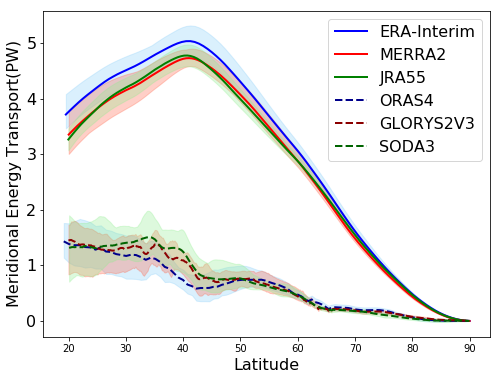

In [9]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & OMET mean 20N - 90N !@#$%^&***********')
    fig1 = plt.figure()
    fig1.set_size_inches(8, 6)
    plt.plot(latitude_fields_ERAI[:95],AMET_ERAI_mean,'b-',linewidth=2.0,label='ERA-Interim')
    plt.fill_between(latitude_fields_ERAI[:95],AMET_ERAI_full_annual_mean_max,AMET_ERAI_full_annual_mean_min,alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    plt.plot(latitude_fields_MERRA2[:141],AMET_MERRA2_mean,'r-',linewidth=2.0,label='MERRA2')
    plt.fill_between(latitude_fields_MERRA2[:141],AMET_MERRA2_full_annual_mean_max,AMET_MERRA2_full_annual_mean_min,alpha=0.3,edgecolor='tomato', facecolor='tomato')
    plt.plot(latitude_fields_JRA55[:125],AMET_JRA55_mean,'g-',linewidth=2.0,label='JRA55')
    plt.fill_between(latitude_fields_JRA55[:125],AMET_JRA55_full_annual_mean_max,AMET_JRA55_full_annual_mean_min,alpha=0.3,edgecolor='lightgreen', facecolor='lightgreen')
    plt.plot(latitude_ORAS4,OMET_ORAS4_mean,color='darkblue',linestyle='--',linewidth=2.0,label='ORAS4')
    plt.fill_between(latitude_ORAS4,OMET_ORAS4_full_annual_mean_max,OMET_ORAS4_full_annual_mean_min,alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    plt.plot(latitude_GLORYS2V3,OMET_GLORYS2V3_mean,color='darkred',linestyle='--',linewidth=2.0,label='GLORYS2V3')
    plt.fill_between(latitude_GLORYS2V3,OMET_GLORYS2V3_full_annual_mean_max,OMET_GLORYS2V3_full_annual_mean_min,alpha=0.3,edgecolor='tomato', facecolor='tomato')
    plt.plot(latitude_SODA3,OMET_SODA3_mean,color='darkgreen',linestyle='--',linewidth=2.0,label='SODA3')
    plt.fill_between(latitude_SODA3,OMET_SODA3_full_annual_mean_max,OMET_SODA3_full_annual_mean_min,alpha=0.3,edgecolor='lightgreen', facecolor='lightgreen')
    plt.xlabel("Latitude",fontsize=16)
    # plt.xticks(,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=1, prop={'size': 16})
    plt.show()
    fig1.savefig(os.path.join(output_path,'MET_res_mean.png'),dpi=300)
    plt.close(fig1)

In [10]:
    print ('***********!@#$%^&*  AMET residual time series & anomalies !@#$%^&***********')
    print ('Prepare data for plots!')
    # time series for comparison
    AMET_res_int_ERAI_series = AMET_res_ERAI.reshape(len(year_ERAI)*12,
                                                         len(latitude_fields_ERAI))
    AMET_res_int_MERRA2_series = AMET_res_MERRA2.reshape(len(year_MERRA2)*12,
                                                         len(latitude_fields_MERRA2))
    AMET_res_int_JRA55_series = AMET_res_JRA55.reshape(len(year_JRA55)*12,
                                                         len(latitude_fields_JRA55))
    # take anomalies (5 years by default)
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)
    stat_AMET_res_ERAI.detrend()
    stat_AMET_res_ERAI.lowpass(obj='detrend')

    stat_AMET_res_MERRA2 = meta.statistics.operator(AMET_res_int_MERRA2_series[:,60])
    stat_AMET_res_MERRA2.anomaly(Dim_month=False)
    stat_AMET_res_MERRA2.detrend()
    stat_AMET_res_MERRA2.lowpass(obj='detrend')

    stat_AMET_res_JRA55 = meta.statistics.operator(AMET_res_int_JRA55_series[:,53])
    stat_AMET_res_JRA55.anomaly(Dim_month=False)
    stat_AMET_res_JRA55.detrend()
    stat_AMET_res_JRA55.lowpass(obj='detrend')
    # time series indes
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016

***********!@#$%^&*  AMET residual time series & anomalies !@#$%^&***********
Prepare data for plots!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


In [11]:
    # statistics
    # standard deviation
    print('std of AMET - ERAI')
    AMET_E_ERAI_std = np.std(AMET_res_int_ERAI_series[:,40])
    print('std of AMET anomalies - ERAI')
    AMET_E_ERAI_white_std = np.std(stat_AMET_res_ERAI._lowpass)
    print('std of AMET - MERRA2')
    AMET_E_MERRA2_std = np.std(AMET_res_int_MERRA2_series[:,60])
    print('std of AMET anomalies - MERRA2')
    AMET_E_MERRA2_white_std = np.std(stat_AMET_res_MERRA2._lowpass)
    print('std of AMET - JRA55')
    AMET_E_JRA55_std = np.std(AMET_res_int_JRA55_series[:,53])
    print('std of AMET anomalies - JRA55')
    AMET_E_JRA55_white_std = np.std(stat_AMET_res_JRA55._lowpass)
    # mean
    print('mean of AMET - ERAI')
    AMET_E_ERAI_mean = np.mean(AMET_res_int_ERAI_series[:,40])
    print('mean of AMET anomalies - ERAI')
    AMET_E_ERAI_white_mean = np.mean(stat_AMET_res_ERAI._lowpass)
    print('mean of AMET - MERRA2')
    AMET_E_MERRA2_mean = np.mean(AMET_res_int_MERRA2_series[:,60])
    print('mean of AMET anomalies - MERRA2')
    AMET_E_MERRA2_white_mean = np.mean(stat_AMET_res_MERRA2._lowpass)
    print('mean of AMET - JRA55')
    AMET_E_JRA55_mean = np.mean(AMET_res_int_JRA55_series[:,53])
    print('mean of AMET anomalies - JRA55')
    AMET_E_JRA55_white_mean = np.mean(stat_AMET_res_JRA55._lowpass)

std of AMET - ERAI
std of AMET anomalies - ERAI
std of AMET - MERRA2
std of AMET anomalies - MERRA2
std of AMET - JRA55
std of AMET anomalies - JRA55
mean of AMET - ERAI
mean of AMET anomalies - ERAI
mean of AMET - MERRA2
mean of AMET anomalies - MERRA2
mean of AMET - JRA55
mean of AMET anomalies - JRA55


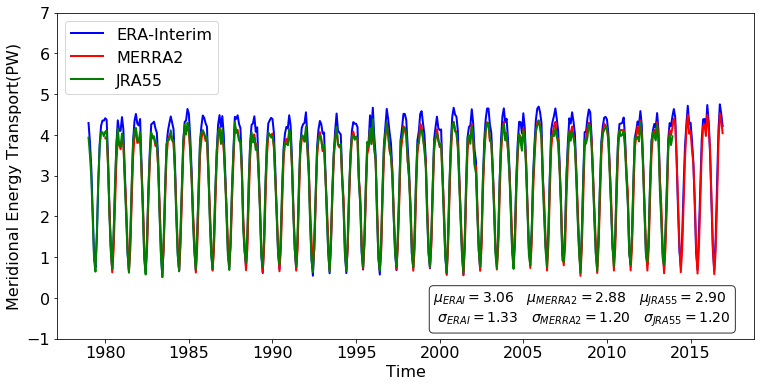

In [14]:
    text_content = '$\mu_{ERAI}=%.2f$   $\mu_{MERRA2}=%.2f$   $\mu_{JRA55}=%.2f$ \n $\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
                % (AMET_E_ERAI_mean, AMET_E_MERRA2_mean, AMET_E_JRA55_mean, AMET_E_ERAI_std, AMET_E_MERRA2_std, AMET_E_JRA55_std)
    # plot AMET time series
    fig = plt.figure()
    fig.set_size_inches(12.5, 6)
    plt.plot(index[:], AMET_res_int_ERAI_series[:,40],
             'b-', linewidth=2.0, label='ERA-Interim')
    plt.plot(index[12:], AMET_res_int_MERRA2_series[:,60],
             'r-', linewidth=2.0, label='MERRA2')
    plt.plot(index[:-36], AMET_res_int_JRA55_series[:,53],
             'g-', linewidth=2.0, label='JRA55')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(np.arange(-1,8), fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    ax.text(0.54,0.15,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
    plt.show()
    fig.savefig(os.path.join(output_path,'AMET_res_series_60N.png'),dpi=300)
    plt.close(fig)

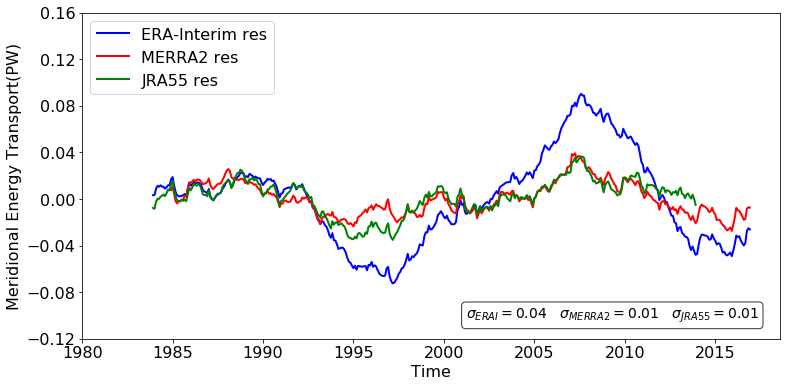

In [19]:
    #text_content = '$\mu_{ERAI}=%.2f$   $\mu_{MERRA2}=%.2f$   $\mu_{JRA55}=%.2f$ \n $\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
    #            % (AMET_E_ERAI_white_mean, AMET_E_MERRA2_white_mean, AMET_E_JRA55_white_mean, AMET_E_ERAI_white_std, AMET_E_MERRA2_white_std, AMET_E_JRA55_white_std)    
    text_content = '$\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
                 % (AMET_E_ERAI_white_std, AMET_E_MERRA2_white_std, AMET_E_JRA55_white_std)    
    # plot AMET anomalies time series with low pass filter
    fig = plt.figure()
    fig.set_size_inches(12.5, 6)
    plt.plot(index[59:], stat_AMET_res_ERAI._lowpass,
             'b-', linewidth=2.0, label='ERA-Interim res')
    plt.plot(index[71:], stat_AMET_res_MERRA2._lowpass,
             'r-', linewidth=2.0, label='MERRA2 res')
    plt.plot(index[59:-36], stat_AMET_res_JRA55._lowpass,
             'g-', linewidth=2.0, label='JRA55 res')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(np.arange(-0.12,0.16,0.04),fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    ax.text(0.55,0.1,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
    plt.show()
    fig.savefig(os.path.join(output_path,'AMET_res_anomaly_lowpass_5y_60N.png'),dpi=300)
    plt.close(fig)

In [20]:
    print ('***********!@#$%^&*  OMET time series & anomalies after detrending !@#$%^&***********')
    print ('Prepare data for plots!')
    # time series for comparison
    OMET_ORAS4_series = OMET_ORAS4[:,:,lat_ORAS4_60_cut].reshape(len(year_ORAS4)*12)
    OMET_GLORYS2V3_series = OMET_GLORYS2V3[:,:,lat_GLORYS2V3_60_cut].reshape(len(year_GLORYS2V3)*12)
    OMET_SODA3_series = OMET_SODA3[:,:,lat_SODA3_60_cut].reshape(len(year_SODA3)*12)
    # take anomalies (5 years by default)
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_ORAS4[:,:,lat_ORAS4_60_cut])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(obj='detrend')

    stat_OMET_GLORYS2V3 = meta.statistics.operator(OMET_GLORYS2V3[:,:,lat_GLORYS2V3_60_cut])
    stat_OMET_GLORYS2V3.anomaly()
    stat_OMET_GLORYS2V3.detrend()
    stat_OMET_GLORYS2V3.lowpass(obj='detrend')

    stat_OMET_SODA3 = meta.statistics.operator(OMET_SODA3[:,:,lat_SODA3_60_cut])
    stat_OMET_SODA3.anomaly()
    stat_OMET_SODA3.detrend()
    stat_OMET_SODA3.lowpass(obj='detrend')
    # series index
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016

***********!@#$%^&*  OMET time series & anomalies after detrending !@#$%^&***********
Prepare data for plots!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!


In [21]:
    # statistics
    # standard deviation
    print('std of OMET - ORAS4')
    OMET_ORAS4_std = np.std(OMET_ORAS4_series)
    print('std of OMET anomalies - ERAI')
    OMET_ORAS4_white_std = np.std(stat_OMET_ORAS4._lowpass)
    print('std of OMET - GLORYS2V3')
    OMET_GLORYS2V3_std = np.std(OMET_GLORYS2V3_series)
    print('std of OMET anomalies - GLORYS2V3')
    OMET_GLORYS2V3_white_std = np.std(stat_OMET_GLORYS2V3._lowpass)
    print('std of OMET - SODA3')
    OMET_SODA3_std = np.std(OMET_SODA3_series)
    print('std of OMET anomalies - SODA3')
    OMET_SODA3_white_std = np.std(stat_OMET_SODA3._lowpass)
    # mean
    print('mean of OMET - ORAS4')
    OMET_ORAS4_mean = np.mean(OMET_ORAS4_series)
    print('mean of OMET anomalies - ORAS4')
    OMET_ORAS4_white_mean = np.mean(stat_OMET_ORAS4._lowpass)
    print('mean of OMET - GLORYS2V3')
    OMET_GLORYS2V3_mean = np.mean(OMET_GLORYS2V3_series)
    print('mean of OMET anomalies - GLORYS2V3')
    OMET_GLORYS2V3_white_mean = np.mean(stat_OMET_GLORYS2V3._lowpass)
    print('mean of OMET - SODA3')
    OMET_SODA3_mean = np.mean(OMET_SODA3_series)
    print('mean of OMET anomalies - SODA3')
    OMET_SODA3_white_mean = np.mean(stat_OMET_SODA3._lowpass)

std of OMET - ORAS4
std of OMET anomalies - ERAI
std of OMET - GLORYS2V3
std of OMET anomalies - GLORYS2V3
std of OMET - SODA3
std of OMET anomalies - SODA3
mean of OMET - ORAS4
mean of OMET anomalies - ORAS4
mean of OMET - GLORYS2V3
mean of OMET anomalies - GLORYS2V3
mean of OMET - SODA3
mean of OMET anomalies - SODA3


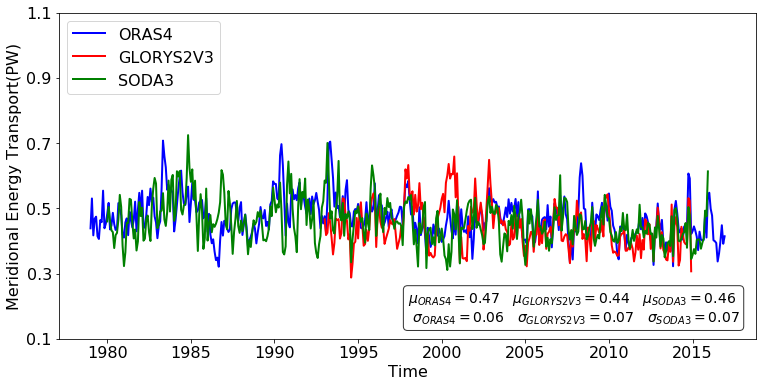

In [36]:
    text_content = '$\mu_{ORAS4}=%.2f$   $\mu_{GLORYS2V3}=%.2f$   $\mu_{SODA3}=%.2f$ \n $\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$' \
                    % (OMET_ORAS4_mean, OMET_GLORYS2V3_mean, OMET_SODA3_mean, OMET_ORAS4_std, OMET_GLORYS2V3_std, OMET_SODA3_std)
    # plot AMET time series
    fig = plt.figure()
    fig.set_size_inches(12.5, 6)
    plt.plot(index[:], OMET_ORAS4_series,
             'b-', linewidth=2.0, label='ORAS4')
    plt.plot(index[168:-24], OMET_GLORYS2V3_series,
             'r-', linewidth=2.0, label='GLORYS2V3')
    plt.plot(index[12:-12], OMET_SODA3_series,
             'g-', linewidth=2.0, label='SODA3')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(np.arange(0.1,1.12,0.2), fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    ax.text(0.5,0.15,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
    plt.show()
    fig.savefig(os.path.join(output_path,'OMET_series_60N.png'),dpi=300)
    plt.close(fig)

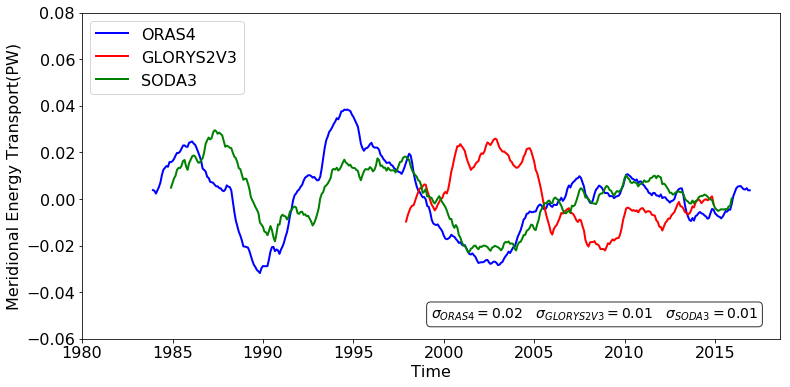

In [37]:
    text_content = '$\sigma_{ORAS4}=%.2f$   $\sigma_{GLORYS2V3}=%.2f$   $\sigma_{SODA3}=%.2f$' \
                    % (OMET_ORAS4_white_std, OMET_GLORYS2V3_white_std, OMET_SODA3_white_std)
    # plot AMET time series
    fig = plt.figure()
    fig.set_size_inches(12.5, 6)
    plt.plot(index[59:], stat_OMET_ORAS4._lowpass,
             'b-', linewidth=2.0, label='ORAS4')
    plt.plot(index[227:-24], stat_OMET_GLORYS2V3._lowpass,
             'r-', linewidth=2.0, label='GLORYS2V3')
    plt.plot(index[71:-12], stat_OMET_SODA3._lowpass,
             'g-', linewidth=2.0, label='SODA3')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(np.arange(-0.06,0.08,0.02),fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    ax.text(0.5,0.1,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
    plt.show()
    fig.savefig(os.path.join(output_path,'OMET_anomaly_lowpass_5y_60N.png'),dpi=300)
    plt.close(fig)